# Train a `bioLORD` model with `developing human immune across tissue` for `bioLORD` (B-cells)

The data was generated by Suo et al.[[1]](https://www.science.org/doi/full/10.1126/science.abo0510) and downloaded from [Lymphoid cells](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad). <br>
The complete dataset contains a cross-tissue single-cell atlas of developing human immune cells across prenatal hematopoietic, lymphoid, and nonlymphoid peripheral organs. This includes over 900,000 cells from which we identified over 100 cell states.

[[1] Suo, Chenqu, Emma Dann, Issac Goh, Laura Jardine, Vitalii Kleshchevnikov, Jong-Eun Park, Rachel A. Botting et al. "Mapping the developing human immune system across organs." Science (2022): eabo0510.](https://www.science.org/doi/full/10.1126/science.abo0510)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/cs/usr/bar246802/bar246802/SandBox2023/biolord_immune_bcells/utils") # add utils
sys.path.append("/cs/usr/bar246802/bar246802/SandBox2023/biolord") # set path)

In [3]:
import biolord
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch
import umap.plot
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from cluster_analysis import *
from formatters import *

/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.14.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
[rank: 0] Global seed set to 0


In [4]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "gpu" if torch.backends.cuda.is_built() else "cpu"
print(f"Using device: {device}")

PyTorch version: 1.13.1+cu117
Using device: gpu


In [5]:
from tqdm import tqdm
tqdm(disable=True, total=0)  # initialise internal lock

In [6]:
import mplscience
mplscience.set_style()

plt.rcParams['legend.scatterpoints'] = 1

## Set parameters

In [7]:
DATA_DIR = "../data/"
SAVE_DIR = "../output/"
FIG_DIR = "../figures/"

## Import processed data

In [8]:
adata = sc.read(DATA_DIR + "biolord_immune_bcells_bm.h5ad")

In [ ]:
adata.obs["split"].value_counts()

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    categorical_attributes_keys=["celltype", "organ", "age"],
    retrieval_attribute_key="sex",
)

## Train model

In [ ]:
# reconstruction_penalty
N_LATENT_ATTRIBUTE_CATEGORICAL = 4
module_params = {
    "autoencoder_width": 128,
    "autoencoder_depth": 2,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": N_LATENT_ATTRIBUTE_CATEGORICAL,
    "loss_ae": "gauss",
    "loss_ordered_attribute": "gauss",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}


trainer_params = {
    "n_epochs_warmup": 0,
    "autoencoder_lr": 1e-4,
    "autoencoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [ ]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="immune_bcells",
    module_params=module_params,
    train_classifiers=False,
    split_key="split",
)

In [ ]:
model.train(max_epochs=1000,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping=True,
            early_stopping_patience=20,            
            check_val_every_n_epoch=10,
            num_workers=1)

## Evaluate the trained model

In [ ]:
size = N_LATENT_ATTRIBUTE_CATEGORICAL
vals = [
    "generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"
]
fig, axs = plt.subplots(nrows=1,
                        ncols=len(vals),
                        figsize=(size * len(vals), size))

model.epoch_history = pd.DataFrame().from_dict(
    model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## Save the trained model

In [ ]:
model.save(SAVE_DIR + "trained_model")

## Load saved model

In [9]:
model = biolord.Biolord.load(dir_path=SAVE_DIR + "trained_model", adata=adata, use_gpu=True)

INFO     File ../output/trained_model/model.pt already downloaded                                                  


[rank: 0] Global seed set to 42


## Assess performance

In [10]:
idx_train = np.where(
    (adata.obs["split"] == "train") 
)[0]

adata_train= adata[idx_train].copy()


idx_test = np.where(
    (adata.obs["split"] == "test")
)[0]

adata_test = adata[idx_test].copy()

dataset_train = model.get_dataset(adata_train)
dataset_test = model.get_dataset(adata_test)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


## Cluster embeddings

In [12]:
attributes_map = {
    "celltype": model.categorical_attributes_map["celltype"],
    "organ": model.categorical_attributes_map["organ"]
}

In [13]:
transf_embeddings_attributes = {
    attribute_:
    model.get_categorical_attribute_embeddings(attribute_key=attribute_)
    for attribute_ in model.categorical_attributes_map
}

keys = list(
    itertools.product(*[
        list(model.categorical_attributes_map[attribute_].keys())
        for attribute_ in model.categorical_attributes_map
    ]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate(([
        transf_embeddings_attributes[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(model.categorical_attributes_map.items())
    ]), 0)
    for key_ in keys
}

transf_embeddings_attributes = [
    np.concatenate(([
        transf_embeddings_attributes[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(model.categorical_attributes_map.items())
    ]), 0) for key_ in keys
]

In [15]:
transf_embeddings_attributes_ind = {
    attribute_:
    model.get_categorical_attribute_embeddings(attribute_key=attribute_)
    for attribute_ in attributes_map
}

keys = list(
    itertools.product(*[
        list(model.categorical_attributes_map[attribute_].keys())
        for attribute_ in attributes_map
    ]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate(([
        transf_embeddings_attributes_ind[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(attributes_map.items())
    ]), 0)
    for key_ in keys
}

transf_embeddings_attributes = [
    np.concatenate(([
        transf_embeddings_attributes_ind[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(attributes_map.items())
    ]), 0) for key_ in keys
]

In [16]:
transf_embeddings_attributes = np.asarray(transf_embeddings_attributes)

In [19]:
pca = sc.tl.pca(transf_embeddings_attributes)

In [20]:
mapper_latent = umap.UMAP().fit_transform(transf_embeddings_attributes)

In [21]:
cols = {
    attribute_ :  [key_[ci] for key_ in keys]
    for ci, attribute_ in enumerate(attributes_map)
}

In [23]:
adata.uns["organ_colors"] = [
    "#029e73", 
    "#949494",
    "#ece133",
    "#de8f05",
    "#ca9161",
    "#fbafe4",
    "#cc78bc",
    "#d55e00",
    "#0173b2",
]

In [24]:
df = pd.DataFrame(mapper_latent, columns=["umap1", "umap2"])
for i in range(pca.shape[1]):
    df[f"pc{i+1}"] = pca[:, i]
for col_, map_ in cols.items():
    df[col_] = map_
    

dfs = {}

for attribute_ in transf_embeddings_attributes_ind:
    dfs[attribute_] = pd.DataFrame(
        transf_embeddings_attributes_ind[attribute_],
        columns=["latent1", "latent2", "latent3", "latent4"])
    dfs[attribute_][attribute_] = list(attributes_map[attribute_].keys())
    dfs[attribute_][attribute_ + '_key'] = list(attributes_map[attribute_].values())
    df[attribute_ + "_key"] = df[attribute_].map(attributes_map[attribute_])

In [25]:
df["celltype"] = df["celltype"].replace(
    {
        "B1": "B1", 
        "CYCLING_B": "cycling B", 
        "IMMATURE_B": "immature B", 
        "LARGE_PRE_B": "large pre B", 
        "LATE_PRO_B": "late pro B", 
        "MATURE_B": "mature B", 
        "PLASMA_B": "palsma B", 
        "PRE_PRO_B": "pre pro B", 
        "PRO_B": "pro B", 
        "SMALL_PRE_B": "small pre B", 
    }
)

In [26]:
df["organ"] = df["organ"].replace(
    {
        "BM": "Bone Marrow", 
        "GU": "Gut", 
        "KI": "Kidney", 
        "LI": "Liver", 
        "MLN": "Lymph Node", 
        "SK": "Skin", 
        "SP": "Spleen", 
        "TH": "Thymus", 
        "YS": "Yolk Sac",
    }
)

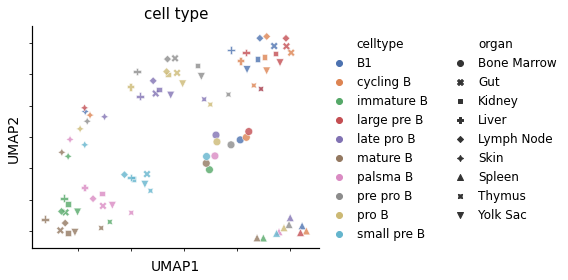

In [27]:
fig, axs = plt.subplots(1,1, figsize=(8,4))


sns.scatterplot(
    data=df, 
    x="umap1", 
    y="umap2", 
    hue="celltype",
    style="organ",
    ax=axs,  
    alpha=.8,
    s=60,
    palette="deep"
)



axs.set_title("cell type")
axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("UMAP1")
axs.set_ylabel("UMAP2")
axs.grid(False)
axs.legend(loc="upper left", bbox_to_anchor=(1, 1), ncols=2)

plt.tight_layout()
plt.savefig(FIG_DIR + "cell_type.png", format="png", dpi=300)

plt.show()


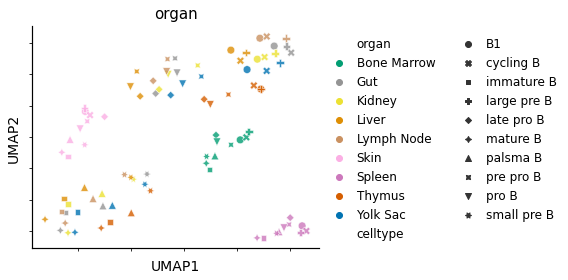

In [28]:
SAVEFIG = False
fig, axs = plt.subplots(1,1, figsize=(8,4))

sns.scatterplot(
    data=df, 
    x="umap1", 
    y="umap2", 
    hue="organ",
    style="celltype",
    ax=axs,  
    alpha=.8,
    s=60,
    palette=[
    "#029e73", 
    "#949494",
    "#ece133",
    "#de8f05",
    "#ca9161",
    "#fbafe4",
    "#cc78bc",
    "#d55e00",
    "#0173b2",
]
)


axs.set_title("organ")
axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("UMAP1")
axs.set_ylabel("UMAP2")
axs.grid(False)
axs.legend(loc="upper left", bbox_to_anchor=(1, 1), ncols=2)

plt.tight_layout()
plt.savefig(FIG_DIR + "organ.png", format="png", dpi=300)

plt.show()


In [29]:
attributes_map_rev = {}
for key in attributes_map:
    attributes_map_rev[key] = {v: k for k, v in attributes_map[key].items()}

In [30]:
attributes_map_rev

{'celltype': {0: 'B1',
  1: 'CYCLING_B',
  2: 'IMMATURE_B',
  3: 'LARGE_PRE_B',
  4: 'LATE_PRO_B',
  5: 'MATURE_B',
  6: 'PLASMA_B',
  7: 'PRE_PRO_B',
  8: 'PRO_B',
  9: 'SMALL_PRE_B'},
 'organ': {0: 'BM',
  1: 'GU',
  2: 'KI',
  3: 'LI',
  4: 'MLN',
  5: 'SK',
  6: 'SP',
  7: 'TH',
  8: 'YS'}}

In [34]:
def cluster_evaluate_figures(attribute_):
    ground_truth_labels = np.array(df[attribute_ + '_key'])
    print("Number of samples:", ground_truth_labels.size)
    title = "Attribute: " + attribute_ 
    path = FIG_DIR + attribute_ + "_"
    scores = matrices_figures(transf_embeddings_attributes, ground_truth_labels, df,
                        attributes_map_rev, attribute_, title, path)

Number of samples: 90
ground truth labels: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 8 8
 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9] 



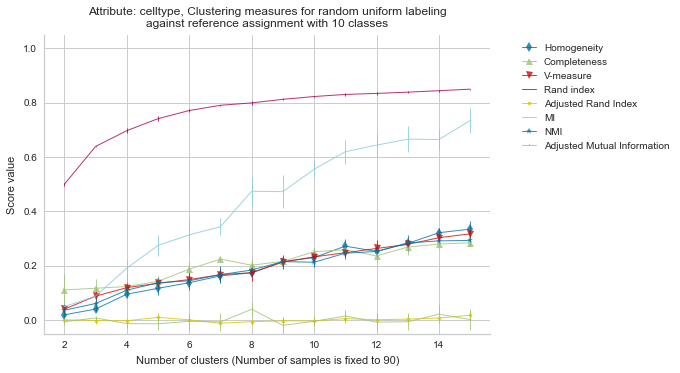

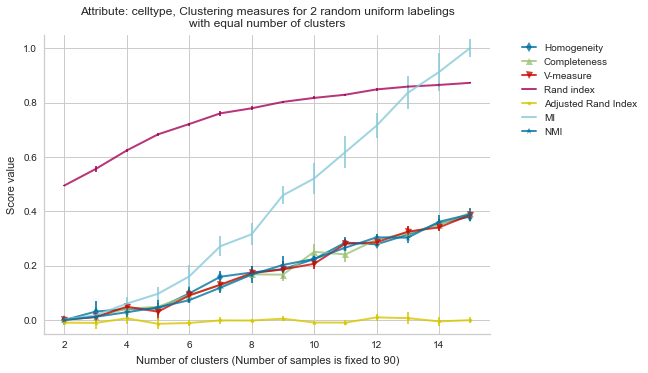

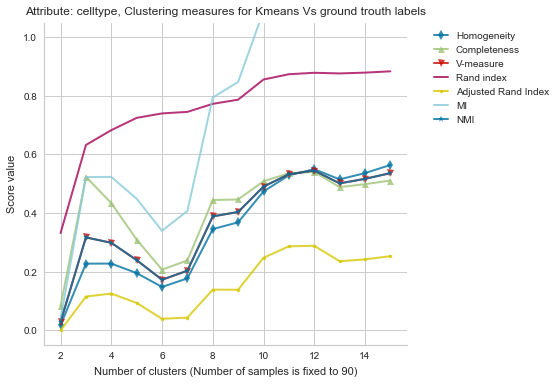

For the label 0:
2: 33.33333333333333%
5: 33.33333333333333%
6: 33.33333333333333%
For the label 0 the new label will be: 2
For the label 1:
4: 29.411764705882355%
7: 35.294117647058826%
8: 35.294117647058826%
For the label 1 the new label will be: 7
For the label 2:
9: 100.0%
For the label 2 the new label will be: 9
For the label 3:
6: 50.0%
9: 50.0%
For the label 3 the new label will be: 6
For the label 4:
0: 14.285714285714285%
1: 14.285714285714285%
3: 14.285714285714285%
4: 14.285714285714285%
7: 14.285714285714285%
8: 14.285714285714285%
9: 14.285714285714285%
For the label 4 the new label will be: 0
For the label 5:
2: 71.42857142857143%
5: 14.285714285714285%
6: 14.285714285714285%
For the label 5 the new label will be: 2
For the label 6:
4: 66.66666666666666%
8: 33.33333333333333%
For the label 6 the new label will be: 4
For the label 7:
0: 11.11111111111111%
1: 11.11111111111111%
2: 11.11111111111111%
3: 11.11111111111111%
4: 11.11111111111111%
5: 11.11111111111111%
6: 11.111

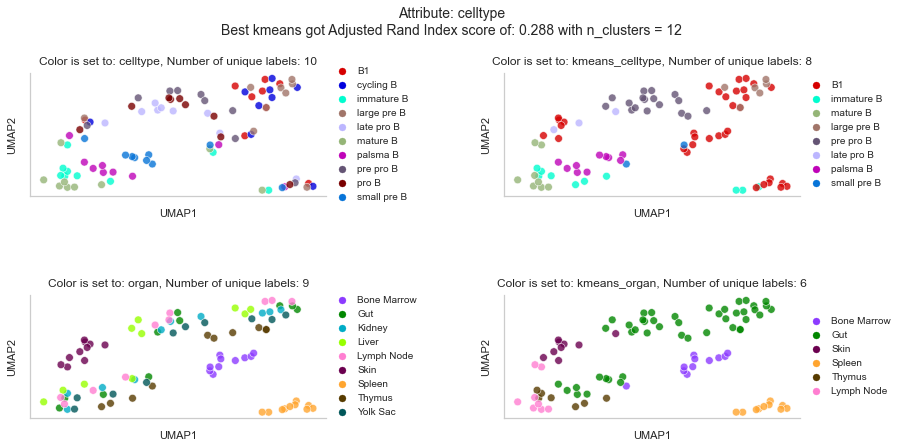

In [62]:
cluster_evaluate_figures("celltype")

Number of samples: 90
ground truth labels: [0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0
 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1
 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8] 



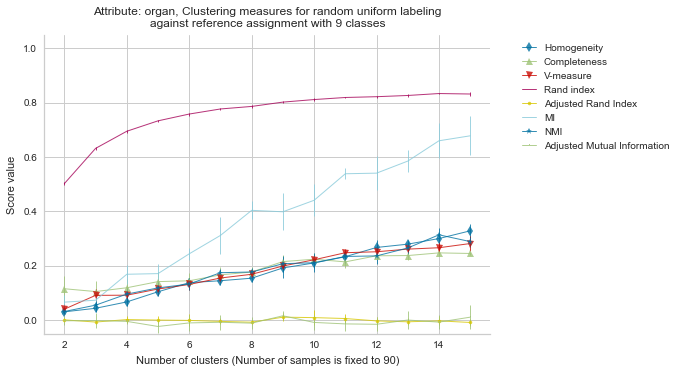

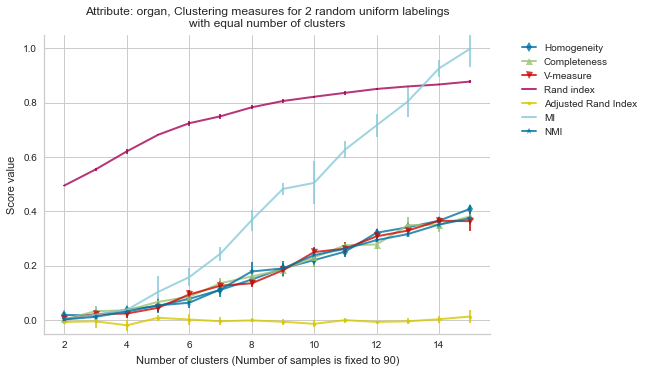

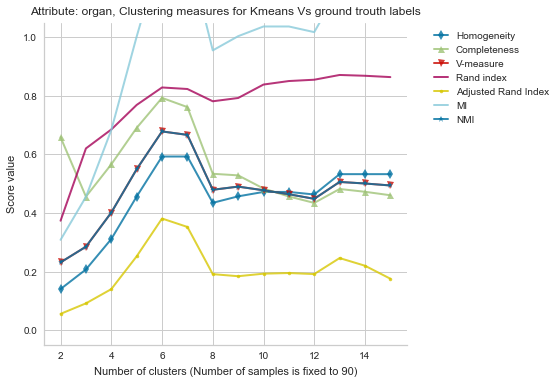

For the label 0:
0: 10.0%
1: 10.0%
2: 10.0%
3: 10.0%
4: 10.0%
5: 10.0%
6: 10.0%
7: 10.0%
8: 10.0%
9: 10.0%
For the label 0 the new label will be: 0
For the label 1:
0: 14.285714285714285%
1: 14.285714285714285%
3: 14.285714285714285%
4: 14.285714285714285%
7: 14.285714285714285%
8: 14.285714285714285%
9: 14.285714285714285%
For the label 1 the new label will be: 0
For the label 2:
0: 10.0%
1: 10.0%
2: 10.0%
3: 10.0%
4: 10.0%
5: 10.0%
6: 10.0%
7: 10.0%
8: 10.0%
9: 10.0%
For the label 2 the new label will be: 0
For the label 3:
0: 10.0%
1: 10.0%
2: 10.0%
3: 10.0%
4: 10.0%
5: 10.0%
6: 10.0%
7: 10.0%
8: 10.0%
9: 10.0%
For the label 3 the new label will be: 0
For the label 4:
0: 10.0%
1: 10.0%
2: 10.0%
3: 10.0%
4: 10.0%
5: 10.0%
6: 10.0%
7: 10.0%
8: 10.0%
9: 10.0%
For the label 4 the new label will be: 0
For the label 5:
2: 33.33333333333333%
5: 33.33333333333333%
6: 33.33333333333333%
For the label 5 the new label will be: 2
For the label 0:
0: 10.0%
1: 10.0%
2: 10.0%
3: 10.0%
4: 10.0%
5: 

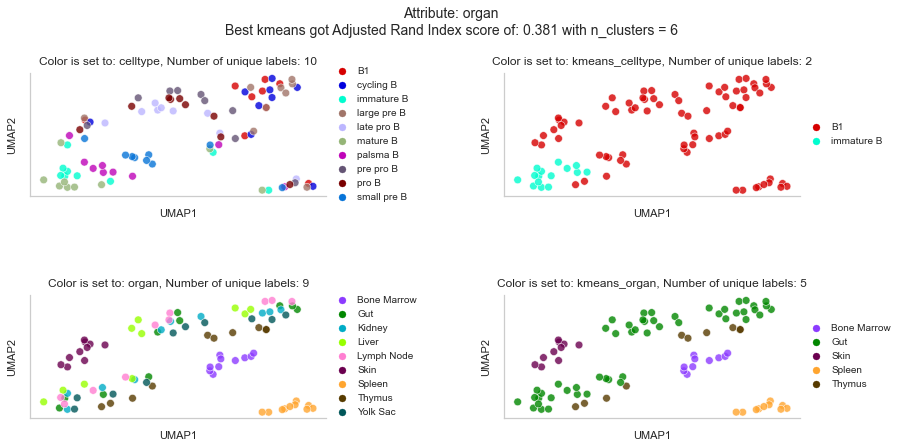

In [63]:
cluster_evaluate_figures("organ")

In [ ]:
def cluster_evaluate(model, attributes = ['celltype', 'organ']):
    transf_embeddings_attributes = get_transf_embeddings_attributes(model)
    all_scores = None
    for attribute in attributes:
        ground_truth_labels = np.array(df[attribute + '_key'])
        ground_truth_unique_labels = list(set(ground_truth_labels))
        print(f'For attribute {attribute} the # of unique true labels is: {len(ground_truth_unique_labels)}')
        scores = get_kmeans_score(transf_embeddings_attributes, ground_truth_labels)
        scores['attribute'] = attribute
        if all_scores is not None:
            all_scores = pd.concat([all_scores, scores], ignore_index=True)
        else:
            all_scores = scores
    cols = ['attribute', 'score_name', 'score', 'n_clusters']
    all_scores = all_scores[cols]
    print(all_scores)
    return all_scores

In [ ]:
cluster_evaluate(model)

In [ ]:
def train_model(module_params, trainer_params):   
    model = biolord.Biolord(
        adata=adata,
        n_latent=32,
        model_name="immune_bcells",
        module_params=module_params,
        train_classifiers=False,
        split_key="split",
    )
    
    model.train(max_epochs=1000,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping=True,
            early_stopping_patience=20,            
            check_val_every_n_epoch=10,
            num_workers=1)
    return model

In [ ]:
def model_training_iterations():
    arr_n_latent_attribute_categorical = np.arange(3, 6)
    arr_reconstruction_penalty = [1e2, 1e3, 1e4]
    arr_unknown_attribute_penalty = [1e-2, 1e-1, 1e1, 1e2]
    arr_unknown_attribute_noise_param = [1e-2, 1e-1, 1e1, 1e2]
    id_ = 1
    full_scores = None
    for n_latent_attribute_categorical, reconstruction_penalty, unknown_attribute_penalty, unknown_attribute_noise_param in itertools.product(
            arr_n_latent_attribute_categorical, arr_reconstruction_penalty,
            arr_unknown_attribute_penalty, arr_unknown_attribute_noise_param):
        print(f"loop index is {id_}")
        module_params = {
            "autoencoder_width": 128,
            "autoencoder_depth": 2,
            "attribute_nn_width": 256,
            "attribute_nn_depth": 2,
            "n_latent_attribute_categorical": n_latent_attribute_categorical,
            "loss_ae": "gauss",
            "loss_ordered_attribute": "gauss",
            "reconstruction_penalty": reconstruction_penalty,
            "unknown_attribute_penalty": unknown_attribute_penalty,
            "unknown_attribute_noise_param": unknown_attribute_noise_param,
            "attribute_dropout_rate": 0.1,
            "use_batch_norm": False,
            "use_layer_norm": False,
            "seed": 42,
        }

        trainer_params = {
            "n_epochs_warmup": 0,
            "autoencoder_lr": 1e-4,
            "autoencoder_wd": 1e-4,
            "attribute_nn_lr": 1e-2,
            "attribute_nn_wd": 4e-8,
            "step_size_lr": 45,
            "cosine_scheduler": True,
            "scheduler_final_lr": 1e-5,
        }
        model = train_model(module_params, trainer_params)
        scores = cluster_evaluate(model)
        scores['n_latent_attribute_categorical'] = n_latent_attribute_categorical
        scores['reconstruction_penalty'] = reconstruction_penalty
        scores['unknown_attribute_penalty'] = unknown_attribute_penalty
        scores['unknown_attribute_noise_param'] = unknown_attribute_noise_param
        if full_scores is not None:
            full_scores = pd.concat([full_scores, scores], ignore_index=True)
        else:
            full_scores = scores

        model.save(SAVE_DIR + "trained_model_" + str(id_), overwrite=True)

        id_ += 1

        full_scores.to_csv(SAVE_DIR + "trained_models_scores.csv")

In [ ]:
model_training_iterations()

In [ ]:
model_training_iterations()

[rank: 0] Global seed set to 42


loop index is 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory biolord_log/immune_bcells_Biolord/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 104/1000:  10%|█         | 104/1000 [07:34<1:05:13,  4.37s/it, v_num=1, val_generative_mean_accuracy=0.45, val_generative_var_accuracy=0.24, val_biolord_metric=0.345, val_reconstruction_loss=255, val_unknown_attribute_penalty_loss=3.88, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=31.2, unknown_attribute_penalty_loss=4]    
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.346. Signaling Trainer to stop.
For attribute celltype the # of unique true labels is: 10
For attribute organ the # of unique true labels is: 9
   attribute                   score_name     score  n_clusters
0   celltype                  Homogeneity  0.494229          15
1   celltype                 Completeness  0.468554          11
2   celltype                    V-measure  0.472073          11
3   celltype                   Rand index  0.875406          15
4   celltype          Adjusted Rand Index  0.193722          11
5 

[rank: 0] Global seed set to 42


loop index is 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory biolord_log/immune_bcells_Biolord/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 104/1000:  10%|█         | 104/1000 [07:33<1:05:08,  4.36s/it, v_num=1, val_generative_mean_accuracy=0.45, val_generative_var_accuracy=0.239, val_biolord_metric=0.345, val_reconstruction_loss=263, val_unknown_attribute_penalty_loss=3.88, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=31.2, unknown_attribute_penalty_loss=4.32] 
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.346. Signaling Trainer to stop.
For attribute celltype the # of unique true labels is: 10
For attribute organ the # of unique true labels is: 9
   attribute                   score_name     score  n_clusters
0   celltype                  Homogeneity  0.418602          15
1   celltype                 Completeness  0.377541          11
2   celltype                    V-measure  0.392165          15
3   celltype                   Rand index  0.867416          15
4   celltype          Adjusted Rand Index  0.107828           8
5

[rank: 0] Global seed set to 42


loop index is 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory biolord_log/immune_bcells_Biolord/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 124/1000:  12%|█▏        | 124/1000 [09:04<1:04:03,  4.39s/it, v_num=1, val_generative_mean_accuracy=0.243, val_generative_var_accuracy=-.263, val_biolord_metric=-.00992, val_reconstruction_loss=33.5, val_unknown_attribute_penalty_loss=2.36, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=32.7, unknown_attribute_penalty_loss=3.2e+3] 
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.162. Signaling Trainer to stop.
For attribute celltype the # of unique true labels is: 10
For attribute organ the # of unique true labels is: 9
   attribute                   score_name     score  n_clusters
0   celltype                  Homogeneity  0.590774          15
1   celltype                 Completeness  0.529788          15
2   celltype                    V-measure  0.558621          15
3   celltype                   Rand index  0.877403          15
4   celltype          Adjusted Rand Index  0.201743        

[rank: 0] Global seed set to 42


loop index is 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory biolord_log/immune_bcells_Biolord/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 249/1000:  25%|██▍       | 248/1000 [17:52<53:51,  4.30s/it, v_num=1, val_generative_mean_accuracy=0.101, val_generative_var_accuracy=-.0687, val_biolord_metric=0.0162, val_reconstruction_loss=35, val_unknown_attribute_penalty_loss=0.0507, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=34.9, unknown_attribute_penalty_loss=3.2e+5]   